# Summer weekends curse <a class="tocSkip">

Have you ever felt like weather has something against you? In the long hot summer days when you are working away at your cubicle, you can't help but wander off imagining how good would it feel to jump right into the water on one of the Absheron beaches. If you live in Baku, that is. And so for the whole week you just count the days until it's weekend and you can finally go to the beach and relax - it is summer, after all. 

Granted, 2020 is not like any other years we've had. Going to the beach was not an option for most of us for almost entirety of this summer. Yet, even then some of you had probably noticed one peculiar phenomena: weekdays are fine and dandy as far as the beach weather go, but as soon as the weekend rolls in - something will surely be off: be it gusts of strong wind, heavy dark clouds or even rain.  

Is it just a coincidence? Or, maybe, our mind plays tricks on us? Can it be that we are just more likely to remember instances of bad weather on the weekends and take instances of good weather for granted? 

Well, wonder no more! Me, your faithful data science ninja, will guide you through years of data to the answer to that secret!

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span><ul class="toc-item"><li><span><a href="#Imports-and-Settings" data-toc-modified-id="Imports-and-Settings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and Settings</a></span></li></ul></li><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Overview

This project analyzes weather data from 2006 to 2020. <br>
Data source: [Reliable Prognosis](https://rp5.ru/) (meteorological station based in Heydar Aliyev Airport)

The goal of this project is to establish correlation (or lack thereof) between weekends and bad weather. Bad weather here defined broadly as weather not suitable for a nice day on the beach.

### Imports and Settings

In [83]:
# Imports
import pandas as pd
import re
from matplotlib import pyplot as plt
# Settings
%matplotlib inline
# To explicitly convert datetime correctly

def dateparse(x): return pd.datetime.strptime(
    x, '%d.%m.%Y %H:%M')  # 29.07.2020 18:30

## Data Loading

Data source contains lots of columns, but not all of them are useful to our purposes. Usually this gets discovered after data is loaded and EDA is performed, however, since website provides legend for the data some of the data features can be omitted straight away.
<br>
Because focus of this analysis is on the weekends vs the rest of the week, numerical indicator of the day is also added.

**Raw columns description**

| Date/Local time | T | Ff | ff10 | ff3 | N or C |
| :- | -: | -: | -: | -: | :-: |
| Local time in this location. Summer time (Daylight Saving Time) is taken into consideration | Air temperature (degrees Celsius) at 2 metre height above the earth's surface | Mean wind speed at a height of 10-12 metres above the earth’s surface over the 10-minute period immediately preceding the observation (meters per second) | Maximum gust value at a height of 10-12 metres above the earth’s surface over the 10-minute period immediately preceding the observation (meters per second) | Maximum gust value at a height of 10-12 metres above the earth’s surface between the periods of observations (meters per second) | Total cloud cover 


In [84]:
# 2006 - 2012
file1 = pd.read_csv('C:\\Users\\NiyaziGaragashli\\Desktop\\Weather_Project\\source\\2006-2012.csv', skiprows=6, sep=";", header=6,
                    usecols=[0, 1, 7, 8, 9, 10], index_col=0, names=["Time", "Temp", "Mean Wind", "Max Wind Gust, 10 (ms)", "Max Wind Gust, b (ms)", "Cloud Coverage"], parse_dates=True, date_parser=dateparse).sort_index()


# 2012 - 2019
file2 = pd.read_csv('C:\\Users\\NiyaziGaragashli\\Desktop\\Weather_Project\\source\\2013-2019.csv', skiprows=6, sep=";", header=6,
                    usecols=[0, 1, 7, 8, 9, 10], index_col=0, names=["Time", "Temp", "Mean Wind", "Max Wind Gust, 10 (ms)", "Max Wind Gust, b (ms)", "Cloud Coverage"], parse_dates=True, date_parser=dateparse).sort_index()


# 2020
file3 = pd.read_csv('C:\\Users\\NiyaziGaragashli\\Desktop\\Weather_Project\\source\\2020.csv', skiprows=6, sep=";", header=6,
                    usecols=[0, 1, 6, 7, 8, 10], index_col=0, names=["Time", "Temp", "Mean Wind", "Max Wind Gust, 10 (ms)", "Max Wind Gust, b (ms)", "Cloud Coverage"], parse_dates=True, date_parser=dateparse).sort_index()

Because data format has changed in 2020 (as many many countless things have), first two files require different type of preparation than the last one.

Cloud coverage contains verbal descriptions and mixed data: both categorical and numerical. 
To circumvent this, a strict numerical map is created. When the initial value is singular, the numerical representation is taken as is; when the initial value is a range, the average is taken.

In [85]:
# Figuring out the values that need mapping
file1['Cloud Coverage'].unique()
file2['Cloud Coverage'].unique()

array(['40%.', 'no clouds', '60%.', '70 – 80%.', '100%.',
       '90  or more, but not 100%', '20–30%.', nan, '50%.',
       '10%  or less, but not 0',
       'Sky obscured by fog and/or other meteorological phenomena.'],
      dtype=object)

In [86]:
# Creating a map
cloud = {'no clouds': 0,
         '70 – 80%.': 75,
        '10%  or less, but not 0': 5,
        '100%.': 100,
        '60%.': 60,
        '40%.': 40,
        '90  or more, but not 100%': 95,
        '50%.': 50,
        '20–30%.': 25,
        'Sky obscured by fog and/or other meteorological phenomena.': 99
        }

In [87]:
# Applying map to first two files
file1['Cloud Num'] = file1['Cloud Coverage'].map(cloud)
file2['Cloud Num'] = file2['Cloud Coverage'].map(cloud)

In [88]:
# The results
file1['Cloud Num'].unique()

array([100.,   5.,  60.,   0.,  40.,  75.,  95.,  50.,  nan,  25.,  99.])

As shown below, 2020 data has more complicated structure. 

To make it useful, first unnecessary descriptions need to be eliminated. And then mapping can be applied.


In [89]:
# 2020 has different structure
file3['Cloud Coverage'].unique()

array(['No Significant Clouds',
       'Few clouds (10-30%) 1800 m, cumulonimbus clouds',
       'Scattered clouds (40-50%) 1800 m, cumulonimbus clouds',
       'Scattered clouds (40-50%) 1650 m, cumulonimbus clouds',
       'Scattered clouds (40-50%) 1740 m, cumulonimbus clouds',
       'Few clouds (10-30%) 1800 m, cumulonimbus clouds , broken clouds (60-90%) 3000 m',
       'Scattered clouds (40-50%), cumulonimbus clouds',
       'Scattered clouds (40-50%) 900 m, cumulonimbus clouds',
       'Few clouds (10-30%) 990 m, cumulonimbus clouds',
       'Few clouds (10-30%) 810 m, cumulonimbus clouds',
       'Few clouds (10-30%) 900 m, cumulonimbus clouds',
       'Few clouds (10-30%), cumulonimbus clouds',
       'Few clouds (10-30%) 840 m, cumulonimbus clouds',
       'Few clouds (10-30%) 690 m', 'Few clouds (10-30%) 510 m',
       'Scattered clouds (40-50%) 510 m',
       'Scattered clouds (40-50%) 1200 m, cumulonimbus clouds',
       'Scattered clouds (40-50%) 1080 m, cumulonimbus clo

In [90]:
def find_clouds_percents(txt):
    """
    Removes everything but the numerical range
    Input: a string of text
    Output: a string of range
    """

    p = re.compile('\(\d+\-\d+\%\)')
    x = p.findall(txt)
    # If pattern did not show in our search, leave the string unchanged
    x = x[0] if len(x) > 0 else txt
    return x

In [91]:
file3['Cloud Num'] = file3['Cloud Coverage'].apply(lambda x: find_clouds_percents(x))

In [92]:
# Much cleaner value selection
file3['Cloud Num'].unique()

array(['No Significant Clouds', '(10-30%)', '(40-50%)', '(60-90%)'],
      dtype=object)

In [93]:
cloud2020 = {'No Significant Clouds': 0,
         '(10-30%)': 20,
        '(40-50%)': 45,
        '(60-90%)': 75
        }

In [94]:
file3['Cloud Num'] = file3['Cloud Num'].map(cloud2020)

Now we can merge data for all years together in a single dataframe.

In [95]:
total_data = file1.append([file2,file3])
total_data['Weekday'] = total_data.index.weekday

## Analysis

Unfortunately, not every feature has been collected for every date. Discrepancy between most features and maximal gusts of wind is too big to be inferred. Therefore, it is best to remove these features all-together.

In [96]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33425 entries, 2006-01-03 07:00:00 to 2020-08-31 20:00:00
Data columns (total 7 columns):
Temp                      33248 non-null float64
Mean Wind                 33265 non-null float64
Max Wind Gust, 10 (ms)    2353 non-null float64
Max Wind Gust, b (ms)     7129 non-null object
Cloud Coverage            33282 non-null object
Cloud Num                 33282 non-null float64
Weekday                   33425 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.3+ MB


In [97]:
# Deleting the columns that contain almost no information
total_data.drop(['Max Wind Gust, 10 (ms)', 'Max Wind Gust, b (ms)',
                 'Cloud Coverage'], axis=1, inplace=True)

While it is entirely possible that the same pattern can be observed across the whole 4 seasons, even the good weather in winter is still a pretty bad weather to go to the beach. 

Going further, only summer months are used.

In [98]:
# Selecting only summer months
summer = total_data[total_data.index.month.isin([6, 7, 8])]
summer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11514 entries, 2006-06-01 07:00:00 to 2020-08-31 20:00:00
Data columns (total 4 columns):
Temp         11481 non-null float64
Mean Wind    11478 non-null float64
Cloud Num    11507 non-null float64
Weekday      11514 non-null int64
dtypes: float64(3), int64(1)
memory usage: 449.8 KB


Not every year is populated on the same level. Years 2006 to 2008 barely contain any information. These years are not useful to our purpose.

In [99]:
summer.groupby(summer.index.year).count()

,Temp,Mean Wind,Cloud Num,Weekday
Time,,,,
2006,68,68,68,68
2007,1,1,1,1
2008,36,36,36,36
2009,592,592,595,597
2010,591,590,599,599
2011,701,697,701,701
2012,712,715,716,716
2013,732,732,733,735
2014,732,733,736,736


Data is not uniformly distributed across the 24 hours for each day. While it is not necessary for the purposes of this project to have hourly data, it might have been of some use should we choose to examine only useful (in relation to beaches) part of the day. 

Thus, data needs to be aggregated on day level so that comparisons can be made.

In [100]:
summer_daily = summer.loc['2009':].resample('D').mean().dropna().sort_index()
summer_daily['WeekdayName'] = summer_daily.index.weekday_name

In [101]:
summer_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1049 entries, 2009-06-01 to 2020-08-31
Data columns (total 5 columns):
Temp           1049 non-null float64
Mean Wind      1049 non-null float64
Cloud Num      1049 non-null float64
Weekday        1049 non-null float64
WeekdayName    1049 non-null object
dtypes: float64(4), object(1)
memory usage: 49.2+ KB


Let's check for correlations between any single indicator and the day of week. 

It is not surprising to see that correlation is almost non-existent. However, while direct correlation is not to be found, it is still possible that there is some skewness to be discovered. 

In [102]:
summer_daily['Temp'].corr(summer_daily['Weekday'])

0.0006952481248710431

In [103]:
summer_daily['Cloud Num'].corr(summer_daily['Weekday'])

-0.006066518715003785

In [104]:
summer_daily['Mean Wind'].corr(summer_daily['Weekday'])

0.0006389215258711769

Let's see the averages per day of week

In [105]:
summer_avg = summer_daily.groupby(['Weekday','WeekdayName']).mean().round(2)
summer_avg

,,Temp,Mean Wind,Cloud Num
Weekday,WeekdayName,,,
0.0,Monday,26.31,3.32,36.00
1.0,Tuesday,26.66,3.17,34.39
2.0,Wednesday,26.75,2.77,33.57
3.0,Thursday,26.71,2.90,34.30
4.0,Friday,26.46,3.13,34.80
5.0,Saturday,26.45,3.38,34.17
6.0,Sunday,26.55,3.07,34.86


Plotting averages may seem like intentionally misleading trick, but let's entertain this idea anyway

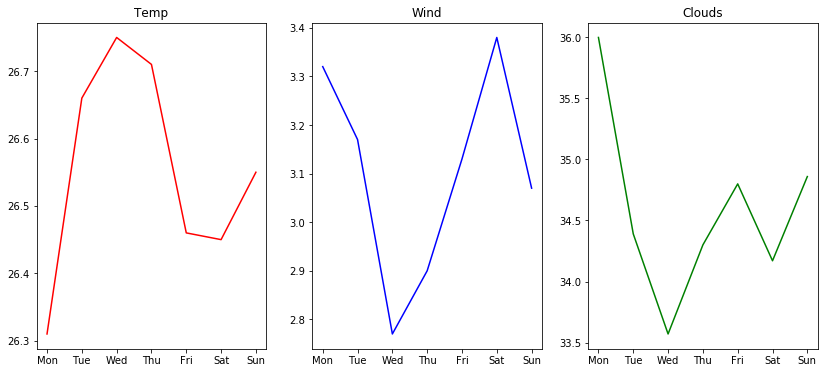

In [106]:
x = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(14, 6))
ax[0].set_title('Temp')
ax[0].plot(x, summer_avg['Temp'], label='Temp', c='r')
ax[1].set_title('Wind')
ax[1].plot(x, summer_avg['Mean Wind'], label='Wind', c='b')
ax[2].set_title('Clouds')
ax[2].plot(x, summer_avg['Cloud Num'], label='Clouds', c='g')

# plt.show()
plt.savefig('summer_vibes.png')

However, averages can be deceiving. As infamous joke goes, "the average temperature in the hospital is 37". So let's instead see distribution of features across one year and all time to see if the pattern holds.

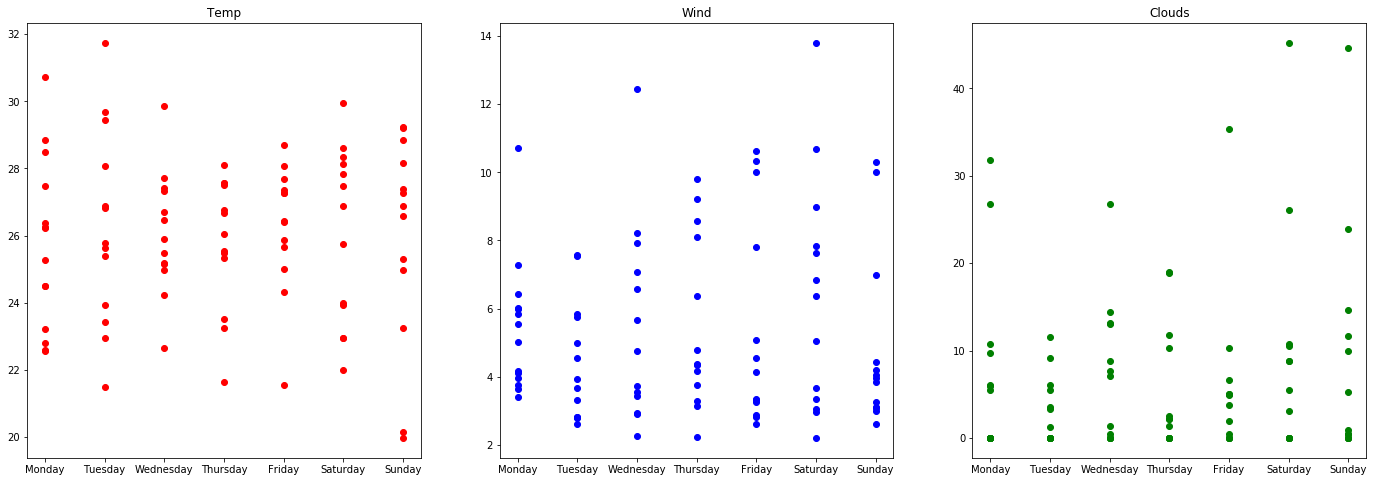

In [107]:
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(24, 8))
ax[0].set_title('Temp')
ax[0].scatter(summer_daily.loc['2020']['WeekdayName'], summer_daily.loc['2020']['Temp'], label='Temp', c='r')
ax[1].set_title('Wind')
ax[1].scatter(summer_daily.loc['2020']['WeekdayName'], summer_daily.loc['2020']['Mean Wind'], label='Wind', c='b')
ax[2].set_title('Clouds')
ax[2].scatter(summer_daily.loc['2020']['WeekdayName'], summer_daily.loc['2020']['Cloud Num'], label='Clouds', c='g')

plt.show()

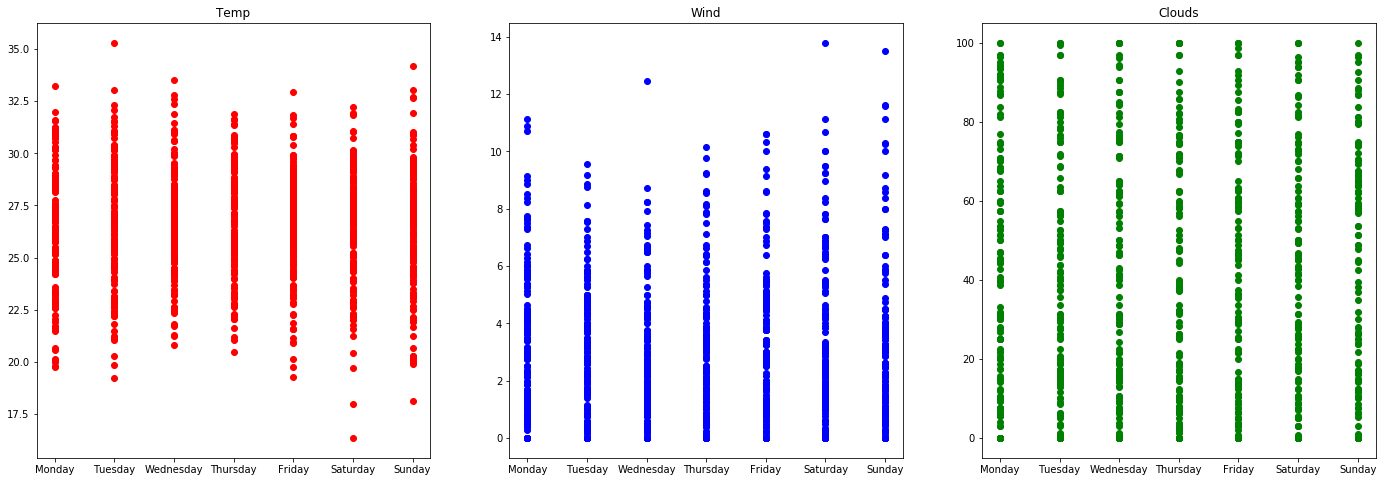

In [108]:
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(24, 8))
x = summer_daily['WeekdayName']
ax[0].set_title('Temp')
ax[0].scatter(x, summer_daily['Temp'], label='Temp', c='r')
ax[1].set_title('Wind')
ax[1].scatter(x, summer_daily['Mean Wind'], label='Wind', c='b')
ax[2].set_title('Clouds')
ax[2].scatter(x, summer_daily['Cloud Num'], label='Clouds', c='g')

plt.show()

We can now clearly see that there is no easily readable pattern that can attribute specific weather to a specific day.

Let's decide on arbitrary features that constitute a good day on the beach:

* It should be at least not colder than the rest of the week
* There should be very little clouds
* And, at best, an easy breeze of a wind

With these limitations, let's count how many such good days were across weekdays

In [109]:
# To get the temperature means for each week, we need to resample original data to weekly frequency
weekly_means = summer.resample('W').mean().round(2).dropna().reset_index()
# Adding new fields year and week for ease of access
weekly_means['Year'] = weekly_means['Time'].dt.year
weekly_means['Week'] = weekly_means['Time'].dt.week
# Removing useless columns
weekly_means.drop(['Time', 'Weekday'], axis=1, inplace=True)

Now there is enough information for us to make a comparisons.

In [110]:
for day in summer_daily.index:
    yr = day.year
    wk = day.week
    temp = summer_daily.loc[day]['Temp']
    wind = summer_daily.loc[day]['Mean Wind']
    clouds = summer_daily.loc[day]['Cloud Num']
    mean_temp = weekly_means[(weekly_means['Year'] == yr)
                             & (weekly_means['Week'] == wk)]['Temp'].item()

    if temp >= mean_temp and clouds < 45 and wind < 8:
        day_ind = 1
    else:
        day_ind = 0
    summer_daily.loc[day, 'GoodDay'] = day_ind

The results are ready to be visualized.

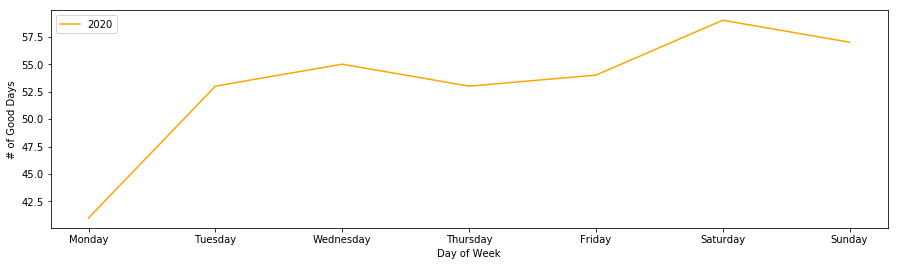

In [111]:
summer_counts = summer_daily.groupby(['Weekday', 'WeekdayName']).sum()[
    'GoodDay'].reset_index()


plt.figure(figsize=(15, 4))
plt.plot(summer_counts['WeekdayName'],
         summer_counts['GoodDay'], label='2020', color='orange')
plt.legend(loc='upper left')
plt.xlabel('Day of Week')
plt.ylabel('# of Good Days')
plt.show()

At first glance it seems that our null hypothesis is completely wrong: if anything, it's the complete opposite! The weekends ARE the best days to go to the beach.

Does this hold true for each year?

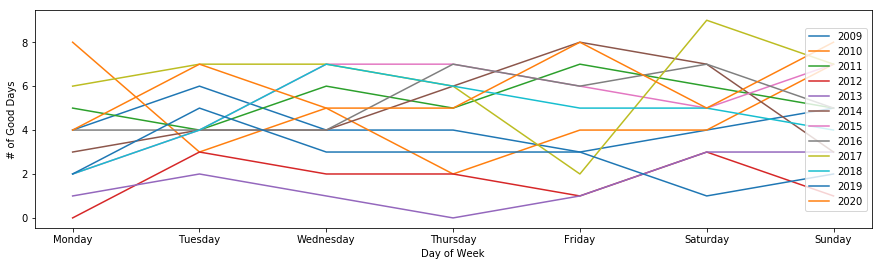

In [112]:
summer_yr_counts = summer_daily.groupby(
    [summer_daily.index.year, 'Weekday', 'WeekdayName']).sum()['GoodDay'].reset_index()


plt.figure(figsize=(15, 4))
for year in summer_yr_counts['Time'].unique():
    plt.plot(summer_yr_counts[summer_yr_counts['Time'] == year]['WeekdayName'],
             summer_yr_counts[summer_yr_counts['Time'] == year]['GoodDay'], label=year)
plt.legend(loc='right')
plt.xlabel('Day of Week')
plt.ylabel('# of Good Days')
plt.show()

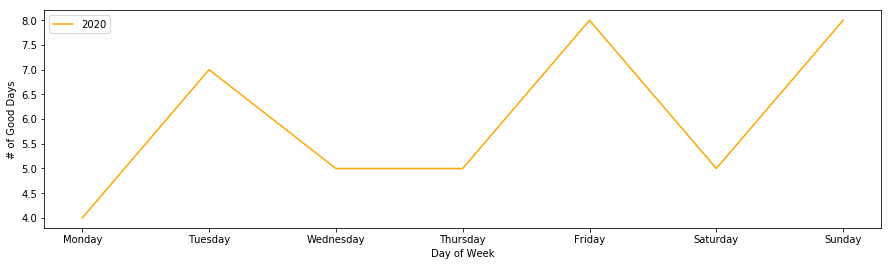

In [113]:
plt.figure(figsize=(15, 4))
plt.plot(summer_yr_counts[summer_yr_counts['Time'] == 2020]['WeekdayName'],
             summer_yr_counts[summer_yr_counts['Time'] == 2020]['GoodDay'], label='2020', color='orange')
plt.legend(loc='upper left')
plt.xlabel('Day of Week')
plt.ylabel('# of Good Days')
plt.show()

## Conclusion

The data shows unequivocally that there is no correlation between what we perceive as good weather and the day of the week.

It seems quite obvious from scientific point of view - should there be any correlation, we would be made aware of that long ago. After all, people study weather since the dawn of time.

Yet, anyone who has ever held an office job in Baku would not agree with that statement. It always felt like weather is custom-made for a good day on the beach all the way through business week, and then everything comes to windy, gloomy, dusty halt on a weekend. 

Of course, my methodology is faulty, to put it mildly. Recently, our Ministry of Emergency Situations employed a system of flags on beaches: green means swimming is safe, yellow means one should exercise caution and red one means no swimming is allowed. If only they would publish this information somewhere! It would make "good day" definition to be much stricter and, at the same time, accurate.

**Pitfalls**:
* Existing data is not as thorough for all the years
* There is no unified definition of what constitutes a good day for the beach

So, if the data says that weekends are nothing special in terms of the weather, how come it is so ingrained in people's perception? This project cannot answer that with any degree of certainty. However, it is often said that negative experiences are far more likely to stay in your memory than neutral ones. We are expecting weekends to be perfect holidays all the time: we plan our trips to rayons, we plan our beach trips and our night life escapades - all on weekends. So whenever weather throws our plans in the trash, we tend to remember the disappointment. And when everything goes as planned, well, we just take it for granted. 

Have a nice weekend!